In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = ''

from encoding_information.gpu_utils import limit_gpu_memory_growth  
limit_gpu_memory_growth()


2024-10-31 10:57:14.101621: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-31 10:57:14.890918: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-10-31 10:57:14.891009: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-10-31 10:57:14.891018: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
import numpy as np

# open the npy files in ./filters and print them
filters_path = '/home/hpinkard_waller/data/filters'
filters = {}
for file in os.listdir(filters_path):
    if file.endswith('.npy'):
        filters[file] = np.load(f'{filters_path}/{file}')

f = np.load(f'{filters_path}/{file}')

for k, v in filters.items():
    print(k) 
    print(np.argmax(v, axis=2))

ideal_1000_photons.npy
[[3 3 0 3 3 0 0 3]
 [2 3 2 0 3 1 3 2]
 [3 0 2 3 0 2 1 3]
 [0 3 3 3 3 0 1 1]
 [0 3 1 3 3 0 3 3]
 [3 3 0 0 3 3 3 0]
 [0 3 3 3 2 0 3 3]
 [0 3 3 0 2 1 3 3]]
bayer_filter.npy
[[0 1 0 1 0 1 0 1]
 [1 2 1 2 1 2 1 2]
 [0 1 0 1 0 1 0 1]
 [1 2 1 2 1 2 1 2]
 [0 1 0 1 0 1 0 1]
 [1 2 1 2 1 2 1 2]
 [0 1 0 1 0 1 0 1]
 [1 2 1 2 1 2 1 2]]
e2e_1000_photons.npy
[[1 2 3 1 3 3 3 1]
 [3 3 3 1 1 1 1 3]
 [1 0 2 3 3 3 3 0]
 [2 3 3 3 3 2 1 1]
 [3 3 3 3 3 3 0 3]
 [0 1 3 3 1 0 3 1]
 [3 3 2 1 1 3 2 2]
 [3 0 3 3 1 2 2 3]]
random_filter.npy
[[1 1 0 1 2 0 1 1]
 [3 0 2 3 2 0 1 3]
 [0 1 1 1 0 3 1 1]
 [0 1 1 0 2 2 0 0]
 [1 2 3 3 1 1 2 3]
 [1 0 2 0 1 0 3 1]
 [2 3 0 2 3 1 3 2]
 [2 2 1 3 1 1 2 0]]


In [3]:
from encoding_information.datasets import ColorFilterArrayDataset
from cleanplots import *
from tqdm import tqdm

tile_size = 128

dataset = ColorFilterArrayDataset('/home/hpinkard_waller/data/four_channel_images.zarr', tile_size=tile_size)

2024-10-31 10:57:16.190304: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:276] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
CUDA backend failed to initialize: FAILED_PRECONDITION: No visible GPU devices. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


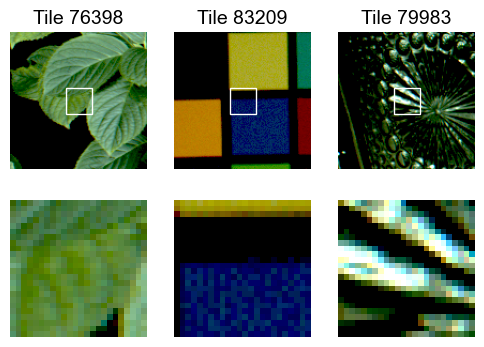

In [4]:
from matplotlib.patches import Rectangle

# Find tiles that look good to show as objects
center_square_size = 24

np.random.seed(19)

for i in tqdm(range(1)):


    if tile_size == 128:
        num_to_show = 10
        # these were good for 128x128 tiles
        # indices = np.random.randint(0, dataset._tiles.shape[0], num_to_show)
        # indices = [ 15741, 79983, 15997, 83209, 52568, 56563, 18218, 17691, 74095, 45194, 66559, 61124, 77682, 76399, 84251, 8438, 33254, 12986,
        # 62290, 22256, 10904, 37047, 70065, 61025, 76398]
        indices = [76398, 83209, 79983]

    elif tile_size == 64:
        indices = np.random.randint(0, dataset._tiles.shape[0], num_to_show)
        # 64x64 tiles
        # indices = [172324, 351278, 347857, 54000, 16118, 171456]
    else:
        raise ValueError("No indices for this tile size")

    tiles = dataset._tiles[indices]
    tiles = tiles[..., :3] # remove gray

    # rescale each tile to max 255
    # tiles = [tile * 255 / np.max(tile) for tile in tiles]
    # tiles = [(tile - np.min(tile)) / (np.max(tile) - np.min(tile)) * 255 for tile in tiles]

    # rescale_for_display = lambda x: np.clip((x / 255 * 3) ** (1 / 2.2), 0, 1)
    rescale_for_display = lambda x: np.clip((x / 255 * 3) ** (1 / 2.2), 0, 1)


    # tile_size = 96
    # tiles = [tile[:96, :96] for tile in tiles]

    # plot tile
    fig, ax = plt.subplots(2, len(tiles), figsize=(2 * len(tiles), 4))
    for i in range(len(tiles)):
        ax[0, i].imshow(rescale_for_display(tiles[i]))
        ax[0, i].set(title=f"Tile {indices[i]}")
        # add a patch for a center square
        ax[0, i].add_patch(Rectangle((tile_size // 2 - center_square_size // 2, tile_size // 2 - center_square_size // 2), center_square_size, 
                    center_square_size, edgecolor='white', facecolor='none'))
        ax[0, i].axis('off')
        
        crop = tiles[i][tile_size // 2 - center_square_size // 2:tile_size // 2 + center_square_size // 2, 
                        tile_size // 2 - center_square_size // 2:tile_size // 2 + center_square_size // 2]
        ax[1, i].imshow(rescale_for_display(crop))
        ax[1, i].axis('off')

fig.savefig('/home/hpinkard_waller/figures/bayer/objects.pdf', transparent=True)

ideal_1000_photons.npy
bayer_filter.npy
e2e_1000_photons.npy
random_filter.npy


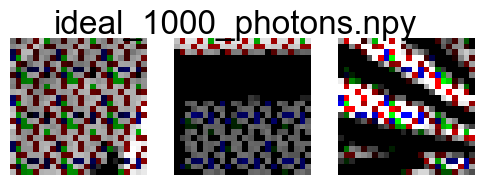

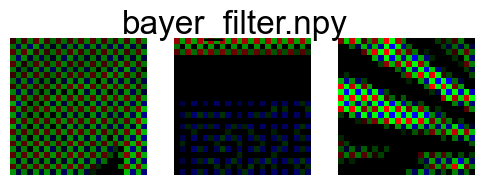

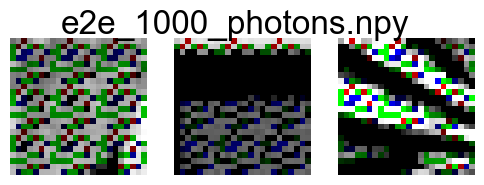

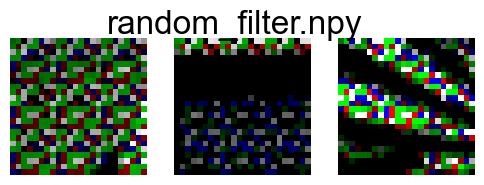

In [5]:
# Plot measurements with noise

filters = []
names = []
for file in os.listdir(f'{filters_path}'):
    if file.endswith('.npy'):
        f = np.load(f'{filters_path}/{file}')
        f = np.argmax(f, axis=2)
        filters.append(f)
        names.append(file)

for f_i, filter_matrix in enumerate(filters):
    print(names[f_i])

    measurements = dataset.get_measurements(mean=1000, bias=0, tile_indices=indices, filter_matrix=filter_matrix)

    measurements = measurements / dataset.rescale_fraction 

    h, w = measurements[0].shape
    filter_h, filter_w = filter_matrix.shape
    tiled_filter = np.tile(filter_matrix, (h // filter_h, h // filter_w))

    # convert back to RGB
    red_image = (tiled_filter == 0) * measurements
    green_image = (tiled_filter == 1) * measurements
    blue_image = (tiled_filter == 2) * measurements
    white_mask = tiled_filter == 3

    # combine into RGB image
    colored_measurements = np.stack([red_image, green_image, blue_image], axis=-1)
    # add white channel
    colored_measurements[:, white_mask] = measurements[:, white_mask][..., None]


    # crop to central square
    edge_crop = (colored_measurements.shape[1] - center_square_size) // 2
    crops = [colored_measurement[edge_crop:-edge_crop, edge_crop:-edge_crop] for colored_measurement in colored_measurements]


    # plot measurements
    fig, ax = plt.subplots(1, len(tiles), figsize=(2 * len(tiles), 2))
    for i in range(len(tiles)):
        # dont flip y
        ax[i].imshow(rescale_for_display(crops[i]), interpolation='none')
        ax[i].axis('off')

    fig.suptitle(f"{names[f_i]}")
    fig.savefig(f'/home/hpinkard_waller/figures/bayer/measurements_{names[f_i]}.pdf', transparent=True)


# Save 40x40 centered images for recon

/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/dask/array/core.py:1712: FutureWarning: The `numpy.save` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


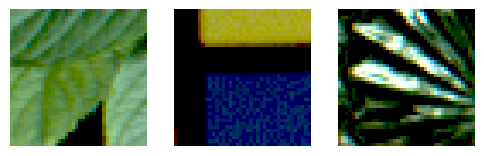

In [29]:
tile_indices = [76398, 83209, 79983]

tiles = dataset._tiles[tile_indices]

# take the central 40x40 square
center_square_size = 40

tiles = [tile[tile_size // 2 - center_square_size // 2:tile_size // 2 + center_square_size // 2,
                tile_size // 2 - center_square_size // 2:tile_size // 2 + center_square_size // 2] for tile in tiles]

# rescale for display
tiles = [rescale_for_display(t[..., :3]) for t in tiles]

fig, ax = plt.subplots(1, 3, figsize=(6, 2))
for i in range(3):
    ax[i].imshow(tiles[i])
    ax[i].axis('off')

# save them as npy files
for i, tile in zip(tile_indices, tiles):
    np.save(f'/home/hpinkard_waller/figures/bayer/tile_{i}.npy', tile)

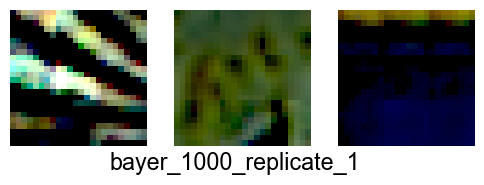

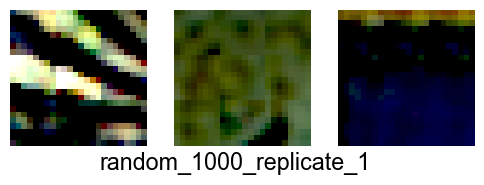

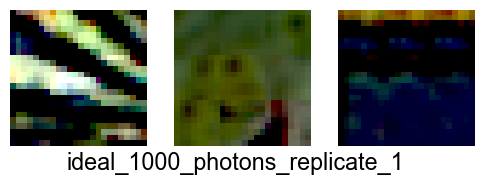

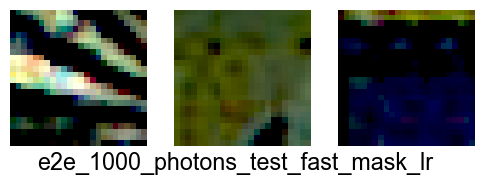

In [18]:
# open all the npy files in the subdirs of 'recon_patches'
import os
import numpy as np
from matplotlib import pyplot as plt
recon_path = '/home/hpinkard_waller/data/figure_patches'

recons = {}
for subdir in os.listdir(recon_path):
    if os.path.isdir(f'{recon_path}/{subdir}'):
        recons[subdir] = []
        for file in os.listdir(f'{recon_path}/{subdir}'):
            if file.endswith('.npy'):
                recons[subdir].append(np.load(f'{recon_path}/{subdir}/{file}'))

rescale_for_display = lambda x: np.clip((x / 255 * 3) ** (1 / 2.2), 0, 1)


# plot them
for subdir in recons.keys():
    fig, ax = plt.subplots(1, 3, figsize=(6, 2))
    for i in range(len(recons[subdir])):
        ax[i].imshow(rescale_for_display(
            recons[subdir][i]), interpolation='none')
        ax[i].axis('off')
    fig.supxlabel(subdir)
    fig.savefig(f'/home/hpinkard_waller/figures/bayer/recons_{subdir}.pdf', transparent=True)
